In [1]:
import sys,os
sys.path.append('..')

In [2]:
from src.callbacks import *
from src.models import *
from src.helpers import *

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD,Adam
import pandas as pd
from IPython.display import Image


# Loading dataset and normalizing features

In [4]:
from tensorflow.keras.datasets import fashion_mnist

In [5]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

In [6]:
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

#Some models require shape sizes of certain proportions. Padding with zeros 
#so that original image doesn't get distorted
resized_trainX = (tf.image.resize_with_pad(trainX,32,32)/255.0).numpy()
resized_testX = (tf.image.resize_with_pad(testX,32,32)/255.0).numpy()


### Changing labels to categorical values by one hot encoding

In [7]:
from tensorflow.keras.utils import to_categorical

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)
labels = ["top", "trouser", "pullover", "dress", "coat","sandal", "shirt", "sneaker", "bag", "ankle boot"]

# Training Models

In [8]:
from tensorflow.keras.applications import MobileNetV2
model_dict = {'MiniVGG':(create_miniVGG(),28),'WideResNet16-4':(WideResidualNetwork(input_shape=(28,28,1)),28),'Basic_CNN_BN':(create_basic_cnn(),28),
              'ShuffleNet':(create_ShufflenetV2(),28),'ShakeResNet34':(create_shakeshake_res34(),32),
              'Resnet18':(ResNet18(dropout=0.25),28),'ResNet34':(ResNet34(dropout=0.25),28),'MobileNet':(MobileNetV2(input_shape=(32,32,1),
                          alpha=1.0,
                          include_top=True,
                          weights=None,
                          input_tensor=None,
                          pooling=None,
                          classes=10),32)}

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


## Callbacks: 

### To speed the convergence of the training, Cyclic learning rates will be used._https://arxiv.org/pdf/1506.01186.pdf_
### Optimal LR rates for can be determined visually by plotting LR-Loss for a few epochs.
### The learning rate will be similar among the models, so plotting one is enough.







In [ ]:
lr_callback = LRFinder(60000, 128,
                       0.0001, 1,
                       lr_scale='exp',validation_data=(testX,testY),verbose=False)
minivgg_model = create_miniVGG()
minivgg_model.compile(loss="categorical_crossentropy", optimizer='sgd',
	metrics=["accuracy"])
history = minivgg_model.fit(trainX, trainY, 
                    epochs=1,
                    batch_size=128,
                    callbacks=[lr_callback])
plt.figure(figsize=(10,10))
lr_callback.plot_schedule()

### Around region where LR converges is optimal. From above graph, around 10^-3.5 and 10^-2.5
### Taking as 10^-2.5 as Max learning rate in the cycle

### stochastic weight averaging is also used. Instead of ensembling different snapshots of the same model,
### Model weights are averaged near the last epochs in the training.


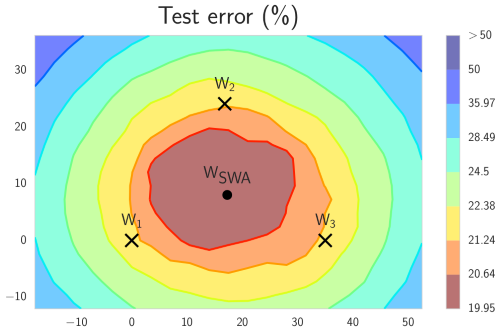

In [9]:
Image("../Images/swa.png")


In [10]:
one_cycle_lr = OneCycleLR(max_lr=0.005,minimum_momentum=None,verbose=0)
callbacks = [one_cycle_lr]

epoch_num=30
optimizer=SGD(lr=1e-2,momentum=0.9,decay=(1e-2)/epoch_num)
swa_opt = SWA(optimizer,start_averaging=24,average_period=2) # Start taking averages of the weights at 40th epoch 

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def train_models_in_batches(model_dict,epoch_num,batch_sz,callbacks=[],optimizer='sgd',augmentations=None):
    if optimizer is 'sgd':
        optimizer=SGD(lr=1e-2,momentum=0.9,decay=(1e-2)/epoch_num)
    model_history = {}
    for name,model_tup in model_dict.items():
        print('training model:',name)
        model,input_size = model_tup
        if input_size==28:
                dataset=trainX
                test_set=testX
        else:
            dataset=resized_trainX
            test_set=resized_testX
        model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
        
        if augmentations:
            name=name+'_aug'
            datagen = ImageDataGenerator(horizontal_flip=0.05,zoom_range=0.05)
            
            datagen.fit(dataset)
            history = model.fit_generator(datagen.flow(dataset,trainY,batch_size=batch_sz),
                                                       epochs=epoch_num,verbose = 0,
                                                       steps_per_epoch = (dataset.shape[0]//batch_sz),
                                                      callbacks=callbacks)
        else:
            history = model.fit(dataset,trainY,epochs=epoch_num,callbacks=callbacks)
        model.save('model_weights/'+name+'.h5')
        hist_df = pd.DataFrame(history.history) 
        predictions = model.predict(test_set)
        # save to json:  
        hist_json_file = 'model_histories/'+name+'_history.json' 
        with open(hist_json_file, mode='w+') as f:
            hist_df.to_json(f)
        mean_accuracy = model.evaluate(test_set,testY,verbose=False)[1]
        model_history[name]=(history.history,mean_accuracy,predictions)
        print('Test Accuracy is ',mean_accuracy)
        K.clear_session()
    
    return model_history
            
            
        

    

In [ ]:
model_histories = train_models_in_batches(model_dict,epoch_num=epoch_num,batch_sz=128,optimizer=swa_opt,
                                         callbacks=[],augmentations=[])

## Data Augmentations

### Minimal augmentations are used since images are small and parameter search takes a while.
#### {'horizontal_flip':0.1,'zoom_range':0.05}

## Classification Results

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
leaderboard = {}
for model_name in model_histories.keys():
    print('######',model_name,'######')
    print(classification_report(testY.argmax(axis=1), model_histories[model_name][2].argmax(axis=1),
        target_names=labels))
    cf_matrix(model_histories[model_name][2],testY,labels,model_name,save=True)
    leaderboard[model_name]=model_histories[model_name][1]

## Test Mean Accuracy

In [ ]:
pd.DataFrame(leaderboard,index=[0])

In [ ]:
print(classification_report(testY.argmax(axis=1), preds.argmax(axis=1),target_names=labelNames))

In [ ]:
predicted_classes= model_histories['WideResNet16-4_aug'][2].argmax(axis=1)
y_test =testY.argmax(axis=1)
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (16,16))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(testX[i].reshape(28,28))
    axes[i].set_title(f"Prediction Class = {predicted_classes[i]:0.1f}\n True Class = {y_test[i]:0.1f}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)